In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

from speedypanther.synthesis.wave_generation import sample_sinewave, sample_complex_wave, generate_impulse_train, generate_noise, generate_timesteps
from speedypanther.shared.plot import plot_waveform, plot_impulse_train

%matplotlib notebook
%matplotlib inline

In [2]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Plot a simple waveform

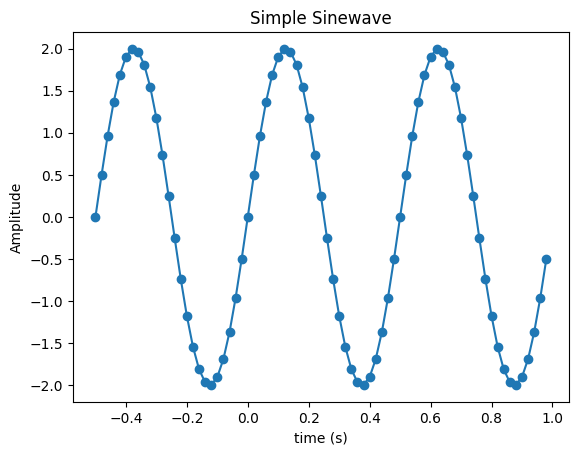

In [3]:
timesteps, samples = sample_sinewave(2, start_time = -0.5, end_time=1.0, amplitude=2, sample_rate=50)
plot_waveform(timesteps, samples, show_samples=True, title="Simple Sinewave")

## Interactively change parameters for simple sine wave

In [4]:
@widgets.interact_manual(
    freq=(0, 100), amplitude=(0.0, 50.0), sample_rate=(0, 44_100), color=['blue', 'red', 'green'], lw=(1., 10.))
def plot_waveform_interactive(freq: int = 1, amplitude: float = 1.0, sample_rate: int = 44_100, color: str = 'blue', lw: int = 1, grid: bool = True, show_samples: bool = False):
    timesteps, samples = sample_sinewave(freq, start_time = 0.0, end_time=1.0, amplitude=amplitude, sample_rate=sample_rate)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(timesteps, samples,
            lw=lw, color=color)
    if show_samples:
        ax.scatter(timesteps, samples)
    ax.grid(grid)

interactive(children=(IntSlider(value=1, description='freq'), FloatSlider(value=1.0, description='amplitude', …

## Plot a complex waveform

In [5]:
complex_timesteps, complex_samples = sample_complex_wave(frequencies=[1, 5, 20], coeffs=[0.3, 0.2, 0.4])

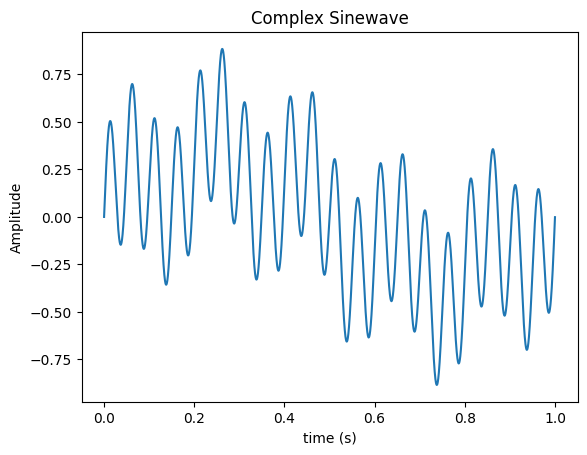

In [6]:
plot_waveform(complex_timesteps, complex_samples, title="Complex Sinewave")

## Interactively choose parameters for a complex wave

In [7]:
@widgets.interact_manual(
    freq1=(0, 100),
    freq2=(0, 100),
    freq3=(0, 100),
    coeff1=(0.0, 1.0),
    coeff2=(0.0, 1.0),
    coeff3=(0.0, 1.0))
def plot_complex_waveform_interactive(freq1=1, freq2=1, freq3=1, coeff1=0.33, coeff2=0.33, coeff3=0.33, grid=True):
    """
    Currently supports 3 waveforms mixed together.
    """
    freqs = [freq1, freq2, freq3]
    coeffs = [coeff1, coeff2, coeff3]
    timesteps, samples = sample_complex_wave(freqs, coeffs)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plt.ylim([-1.05, 1.05])
    plt.xlabel("time (s)")
    plt.ylabel("Amplitude")
    plt.title("Complex Sinewave")
    ax.plot(timesteps, samples)
    ax.grid(grid)

interactive(children=(IntSlider(value=1, description='freq1'), IntSlider(value=1, description='freq2'), IntSli…

## Plot an impulse train

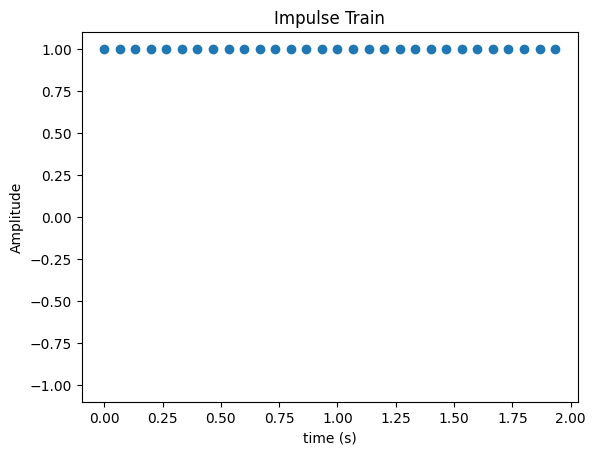

In [8]:
train_timesteps, train_samples = generate_impulse_train(15, end_time=2.0)
plot_impulse_train(train_timesteps, train_samples)

## Plot random noise

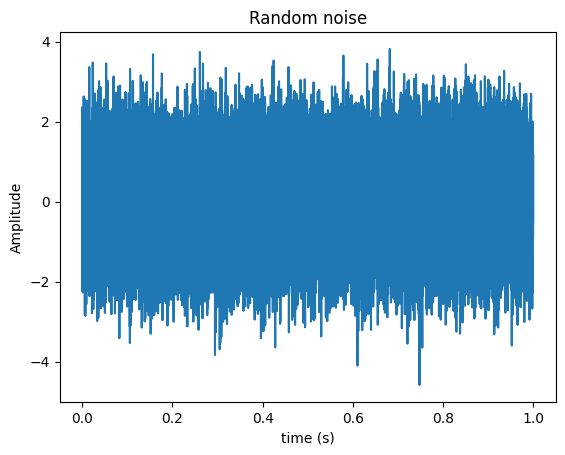

In [9]:
noise_timesteps, noise_samples = generate_noise()
plot_waveform(noise_timesteps, noise_samples, title="Random noise")